In [1]:
import argparse
import os
import torch
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
import random
import numpy as np

In [2]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='TimesNet')

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')
parser.add_argument('--w_lin', type=float, default=1.0, help='initial weight of the linear model')


args = parser.parse_args([])
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(task_name='long_term_forecast', is_training=1, model_id='test', model='Autoformer', data='ETTm1', root_path='./data/ETT/', data_path='ETTh1.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, seasonal_patterns='Monthly', mask_rate=0.25, anomaly_ratio=0.25, top_k=5, num_kernels=6, enc_in=7, dec_in=7, c_out=7, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=1, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='MSE', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[128, 128], p_hidden_layers=2, w_lin=1.0)


In [3]:
args.root_path = "./dataset/electricity/"
args.data_path = "electricity.csv"
args.model = "Client"
args.data = "custom"
var_num = 321
args.d_model = 512
args.seq_len = 96
args.pred_len = 96
args.label_len = 48
args.d_ff = 2048
args.enc_in = var_num
args.dec_in = var_num
args.c_out = var_num
args.output_attention = True

In [4]:
Exp = Exp_Long_Term_Forecast
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.task_name,
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, 0)
exp = Exp(args)

Use GPU: cuda:0


In [5]:
exp.model

Model(
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=96, out_features=96, bias=True)
          (key_projection): Linear(in_features=96, out_features=96, bias=True)
          (value_projection): Linear(in_features=96, out_features=96, bias=True)
          (out_projection): Linear(in_features=96, out_features=96, bias=True)
        )
        (conv1): Conv1d(96, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 96, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (proj): Linear(in_features=96

In [6]:
ecl_model = torch.load("checkpoints/long_term_forecast_ECL_96_96_Client_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/checkpoint.pth")
exp.model.load_state_dict(ecl_model)

<All keys matched successfully>

In [7]:
train_data, train_loader = exp._get_data(flag='train')
test_data, test_loader = exp._get_data(flag='test')

train 18221
test 5165


In [8]:
(batch_x, batch_y, batch_x_mark, batch_y_mark) = next(iter(test_loader))
batch_x = batch_x.float().to('cuda:0')
batch_x_mark = batch_x_mark.float().to('cuda:0')
batch_y = batch_y.float().to('cuda:0')
batch_y_mark = batch_y_mark.float().to('cuda:0')
dec_inp = torch.zeros_like(batch_y[:, -96:, :]).float()
dec_inp = torch.cat([batch_y[:, :48, :], dec_inp], dim=1).float().to('cuda:0')

In [9]:
outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

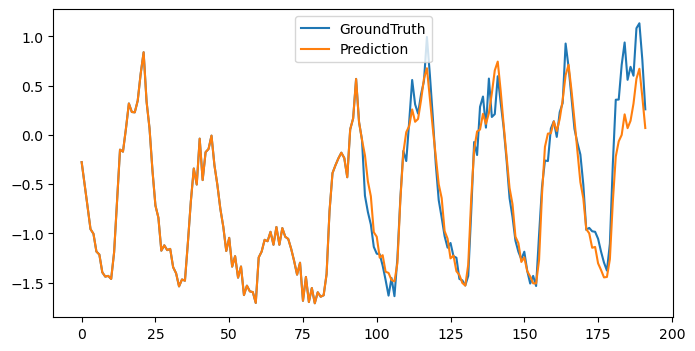

In [10]:
# prediction visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,4))
# %config InlineBackend.figure_format = 'png'
pred = outputs[0].detach().cpu().numpy()
true = batch_y[:, -96:, :].detach().cpu().numpy()
hist = batch_x.detach().cpu().numpy()
gt = np.concatenate((hist[0, :, -1], true[0, :, -1]), axis=0)
pd = np.concatenate((hist[0, :, -1], pred[0, :, -1]), axis=0)
plt.plot(gt, label="GroundTruth")
plt.plot(pd, label="Prediction")
plt.legend()

(array([  1.,   2.,   1.,   1.,   3.,   7.,  15.,  50., 106., 135.]),
 array([0.35635632, 0.40736803, 0.45837972, 0.50939143, 0.56040311,
        0.61141479, 0.66242653, 0.71343821, 0.76444989, 0.81546164,
        0.86647332]),
 <BarContainer object of 10 artists>)

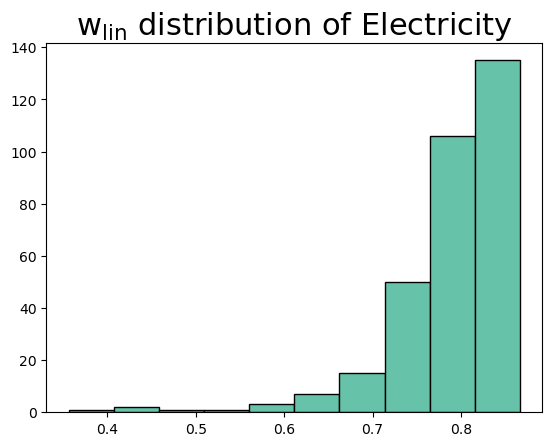

In [11]:
# w_lin distribution
plt.title('$\mathregular{w_{lin}}$ distribution of Electricity',fontsize=22)
plt.hist(exp.model.w_dec.cpu().detach().numpy(),color='#66C2A9',label="FS",edgecolor='black')

<Axes: >

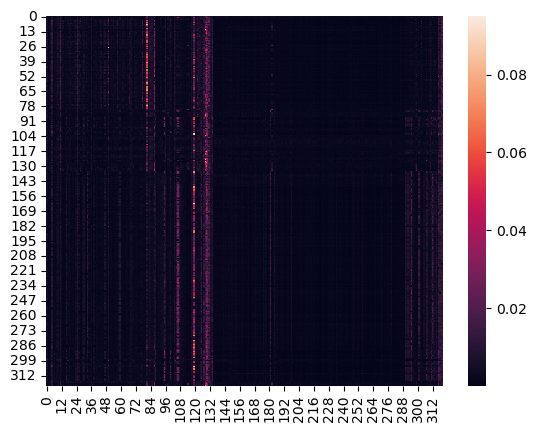

In [12]:
# attention visualization
attention = outputs[1]
import seaborn as sns
sns.heatmap(attention[1][0].mean(dim=0).cpu().detach().numpy())